## 获取数据

In [2]:
# 股票数据
import pandas_datareader.data as web
import datetime
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2024, 1, 1)
df = web.DataReader('GOOGL', 'stooq', start, end)
df.dropna(inplace=True)
df.sort_index(inplace=True)
print(df)

                Open      High       Low     Close    Volume
Date                                                        
2020-01-02   67.4205   68.4340   67.3245   68.4340  27285300
2020-01-03   67.4000   68.6875   67.3660   68.0760  23412580
2020-01-06   67.5815   69.9160   67.5500   69.8905  46786860
2020-01-07   70.0230   70.1750   69.5780   69.7555  34529120
2020-01-08   69.7410   70.5925   69.6315   70.2520  35325480
...              ...       ...       ...       ...       ...
2023-12-22  140.7700  141.9900  140.7100  141.4900  26532199
2023-12-26  141.5900  142.6800  141.1900  141.5200  16780333
2023-12-27  141.5900  142.0800  139.8860  140.3700  19628618
2023-12-28  140.7800  141.1400  139.7500  140.2300  16045712
2023-12-29  139.6300  140.3600  138.7800  139.6900  18733017

[1006 rows x 5 columns]


In [ ]:
# 负荷数据
import pandas as pd
filename = 'data\electricity.csv'
df = pd.read_csv(filename).iloc[:1000,:]
df.dropna(inplace=True)
df.sort_index(inplace=True)
print(df)

## 输入输出

In [3]:
# mem_his_days=5
# per_days=10
# df.dropna(inplace=True)
# df.sort_index(inplace=True)

# df['label'] = df['Close'].shift(-per_days)
df.iloc[:,:]

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,67.4205,68.4340,67.3245,68.4340,27285300
2020-01-03,67.4000,68.6875,67.3660,68.0760,23412580
2020-01-06,67.5815,69.9160,67.5500,69.8905,46786860
2020-01-07,70.0230,70.1750,69.5780,69.7555,34529120
2020-01-08,69.7410,70.5925,69.6315,70.2520,35325480
...,...,...,...,...,...
2023-12-22,140.7700,141.9900,140.7100,141.4900,26532199
2023-12-26,141.5900,142.6800,141.1900,141.5200,16780333
2023-12-27,141.5900,142.0800,139.8860,140.3700,19628618


In [4]:
# def stock_price_lstm_data_precesing(df,mem_his_days=5,per_days=10):

mem_his_days=5
per_days=10
# df.dropna(inplace=True)
# df.sort_index(inplace=True)

# 股票数据
df['label'] = df['Close'].shift(-per_days)
# 负荷数据
# df['label'] = df['OT'].shift(-per_days)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sca_X = scaler.fit_transform(df.iloc[:,1:-1])
# sca_X = np.array(df.iloc[:,:-1])
# print(sca_X)

from collections import deque
deq = deque(maxlen=mem_his_days)

X = []
for i in sca_X:
    deq.append(list(i))
    if len(deq)==mem_his_days:
        X.append(list(deq))

X_lately = X[-per_days:]
X = X[:-per_days]
y = df['label'].values[mem_his_days-1:-per_days]

import numpy as np
X = np.array(X)
y = np.array(y)

    # return X,y,X_lately

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# sca_X = scaler.fit_transform(df.iloc[:,:-1])
# # sca_X = df.iloc[:,:-1]
# print(sca_X)

In [ ]:
# X,y,X_lately = stock_price_lstm_data_precesing(df,mem_his_days=5,per_days=50)

In [5]:
print(X.shape)
print(y.shape)
print(len(X_lately))

(992, 5, 4)
(992,)
10


In [6]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

# LSTM

## 参数寻优

In [ ]:
# mem_days = [5,10,15]
# lstm_layers = [1,2,3]
# dens_layers = [1,2,3]
# units = [8,16,32]
mem_days = [5]
lstm_layers = [1]
dens_layers = [1]
units = [32]
from tensorflow.keras.callbacks import ModelCheckpoint
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dens_layers in dens_layers:
            for the_units in units:
                # save model
                filepath = '{val_mape:.2f}_{epoch:02d}'+f'_mem_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dens_layers}_unit_{the_units}'
                checkpoint = ModelCheckpoint(
                    filepath=filepath,
                    save_weights_only=False,
                    monitor='val_mape',
                    mode='min',
                    save_best_only=True)
                # print(filepath)
                X,y,X_lately = stock_price_lstm_data_precesing(df,mem_his_days=the_mem_days,per_days=10)
                from sklearn.model_selection import train_test_split
                X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False,test_size=0.1)

                import tensorflow as tf
                from tensorflow.keras.models import Sequential
                from tensorflow.keras.layers import LSTM,Dense,Dropout
                model = Sequential()
                model.add(LSTM(the_units,input_shape=X.shape[1:],activation='relu',return_sequences=True))
                model.add(Dropout(0.1))
            
                for i in range(the_lstm_layers):
                    model.add(LSTM(the_units,activation='relu',return_sequences=True))
                    model.add(Dropout(0.1))
                model.add(LSTM(the_units,activation='relu'))
                model.add(Dropout(0.1))

                for i in range(the_dens_layers):
                    model.add(Dense(the_units,activation='relu'))
                    model.add(Dropout(0.1))
                model.add(Dense(1))
                # model.summary()
                model.compile(optimizer='adam',loss='mse',metrics=['mape'])
                model.fit(X_train,y_train,batch_size=32,epochs=50,
                          validation_data=(X_test,y_test),
                          callbacks=[checkpoint])

                

## 构建网络

In [7]:
X.shape[1]

5

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
model = Sequential(name="lstm_m5_p10")
model.add(LSTM(32,input_shape=X.shape[1:],activation='relu',return_sequences=True))
model.add(Dropout(0.1))
# model.add(LSTM(32,activation='relu',return_sequences=True))
# model.add(Dropout(0.1))
model.add(LSTM(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.summary()

Model: "lstm_m5_p10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 32)             4736      
_________________________________________________________________
dropout (Dropout)            (None, 5, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = 'save_model\\lstm'+'_val_mape{val_mape:.2f}_epoch{epoch:02d}_'+f'InputShape(None,{X.shape[1]},{X.shape[2]})'
checkpoint = ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_mape',
    mode='min',
    save_best_only=True)
model.compile(optimizer='adam',loss='mse',metrics=['mape'])
model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test),callbacks=[checkpoint])

Epoch 1/50
28/28 [==============================] - 2s 14ms/step - loss: 213.1714 - mape: 10.8531 - val_loss: 46.1815 - val_mape: 5.3571
INFO:tensorflow:Assets written to: save_model\lstm_val_mape5.36_epoch01_InputShape(None,5,4)\assets
Epoch 2/50
28/28 [==============================] - 0s 4ms/step - loss: 172.5950 - mape: 9.4256 - val_loss: 54.2990 - val_mape: 5.8586
Epoch 3/50
28/28 [==============================] - 0s 4ms/step - loss: 163.7933 - mape: 9.5855 - val_loss: 42.1721 - val_mape: 5.1944
INFO:tensorflow:Assets written to: save_model\lstm_val_mape5.19_epoch03_InputShape(None,5,4)\assets
Epoch 4/50
28/28 [==============================] - 0s 4ms/step - loss: 163.7621 - mape: 9.5064 - val_loss: 42.2697 - val_mape: 5.2215
Epoch 5/50
28/28 [==============================] - 0s 4ms/step - loss: 179.5928 - mape: 10.1164 - val_loss: 46.6872 - val_mape: 5.3864
Epoch 6/50
28/28 [==============================] - 0s 4ms/step - loss: 168.4774 - mape: 9.2537 - val_loss: 49.0053 - val_

## 读取推理

In [12]:
from tensorflow.keras.models import load_model
best_model = load_model('save_model\lstm_val_mape4.85_epoch78_InputShape(None,5,4)')
best_model.summary()

Model: "lstm_m5_p10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 32)             4736      
_________________________________________________________________
dropout (Dropout)            (None, 5, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 

In [13]:
best_model.evaluate(X_test,y_test)
pre = best_model.predict(X_test)
print(pre)

4/4 [==============================] - 0s 2ms/step - loss: 38.6297 - mape: 4.8456
[[139.83533 ]
 [111.42976 ]
 [138.6673  ]
 [116.40985 ]
 [ 86.44325 ]
 [ 90.41778 ]
 [ 76.355896]
 [111.01558 ]
 [132.57791 ]
 [138.95258 ]
 [125.39838 ]
 [ 77.37145 ]
 [ 80.82112 ]
 [ 64.77262 ]
 [ 83.58506 ]
 [114.581726]
 [ 88.15967 ]
 [ 73.21704 ]
 [ 90.908646]
 [116.76191 ]
 [104.53173 ]
 [131.81174 ]
 [106.49103 ]
 [ 76.060074]
 [116.09599 ]
 [109.916794]
 [ 99.85956 ]
 [ 99.38403 ]
 [ 96.245865]
 [ 75.13199 ]
 [ 72.42759 ]
 [ 74.329605]
 [136.1212  ]
 [ 88.03462 ]
 [135.10945 ]
 [140.91745 ]
 [134.20308 ]
 [ 99.254616]
 [137.0995  ]
 [118.909744]
 [101.49469 ]
 [144.51389 ]
 [134.6     ]
 [122.241104]
 [106.86612 ]
 [141.89099 ]
 [120.86532 ]
 [ 90.71899 ]
 [ 76.259605]
 [117.53791 ]
 [141.11732 ]
 [ 93.79895 ]
 [133.42929 ]
 [111.13993 ]
 [122.69588 ]
 [ 68.25966 ]
 [ 97.5374  ]
 [ 87.4527  ]
 [ 75.438   ]
 [ 96.70679 ]
 [105.413574]
 [102.94867 ]
 [131.5943  ]
 [ 76.66704 ]
 [108.90622 ]
 [110.96

In [14]:
print(X_test.shape)
print(y_test.shape)
print(pre.shape)

(100, 5, 4)
(100,)
(100, 1)


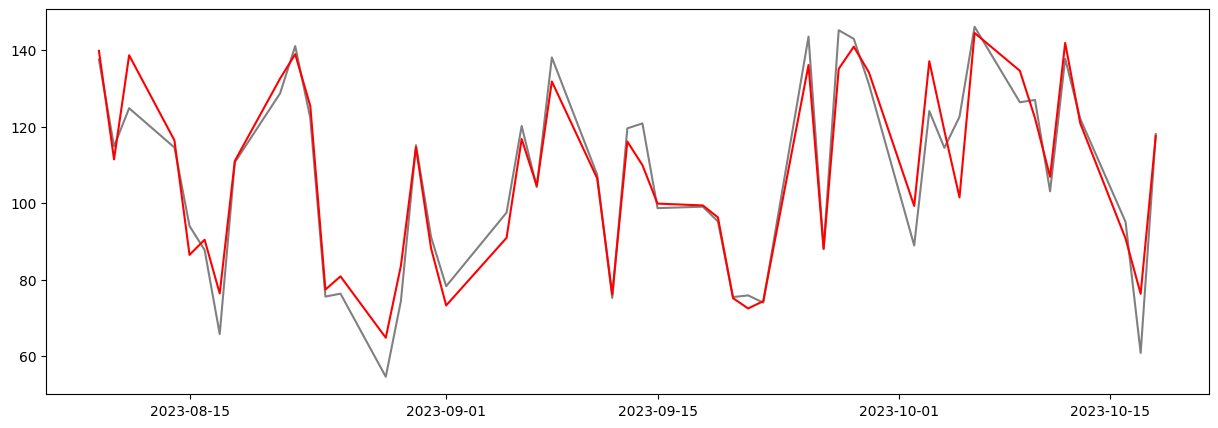

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time[:50],y_test[:50],color='gray',label='price')
plt.plot(df_time[:50],pre[:50],color='red',label='predict')
plt.show()

In [18]:
X.shape

(992, 5, 4)

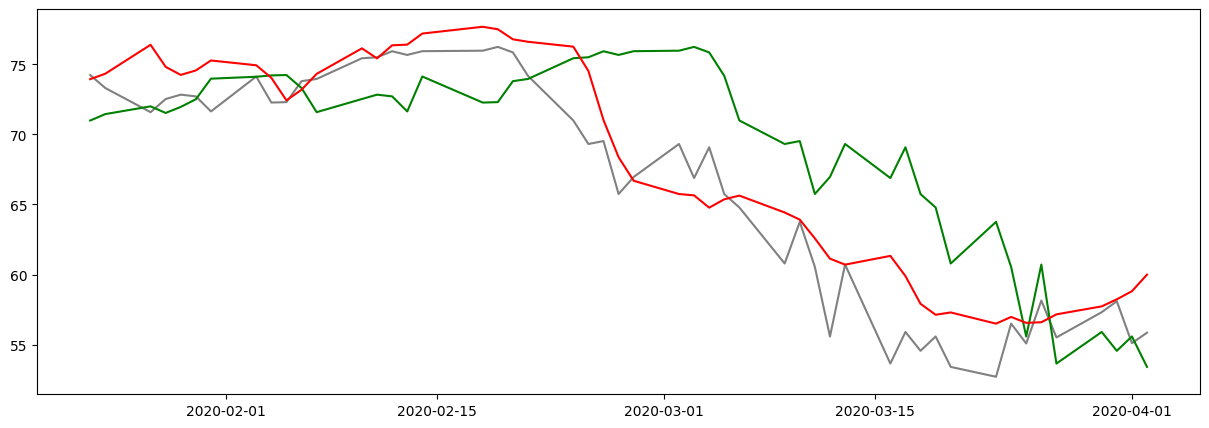

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y):]
show_len = np.arange(50)
plt.plot(df_time[show_len],y[show_len],color='gray',label='price')
plt.plot(df_time[show_len],df['Close'].values[show_len+5],color='green',label='price')
plt.plot(df_time[show_len],best_model.predict(X)[show_len+10],color='red',label='predict')
plt.show()

## pytorch

In [19]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# 假设X_train, y_train, X_test, y_test已经是PyTorch张量格式
# X_train, y_train, X_test, y_test = ...

# 将数据转换为PyTorch的DataLoader
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定义LSTM网络结构
class LSTMNet(nn.Module):
    def __init__(self):
        super(LSTMNet, self).__init__()
        self.hidden_dim = 32
        self.num_layers = 3
        self.dropout = 0.1
        
        self.lstm1 = nn.LSTM(input_size=X_train.shape[1:], hidden_size=self.hidden_dim, 
                              num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.lstm2 = nn.LSTM(self.hidden_dim, self.hidden_dim, 
                              num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.lstm3 = nn.LSTM(self.hidden_dim, self.hidden_dim, 
                              num_layers=self.num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(self.hidden_dim, 32)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        # 通过第一个LSTM
        out, _ = self.lstm1(x)
        
        # 通过第二个LSTM
        out, _ = self.lstm2(out)
        
        # 通过第三个LSTM
        out, _ = self.lstm3(out)
        
        # 通过全连接层
        out = self.fc1(out[:, -1, :])
        out = torch.relu(out)
        out = self.fc2(out)
        
        return out

# 实例化网络
model = LSTMNet()

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# 训练模型
num_epochs = 50
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# 在测试集上评估模型
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        predictions = model(inputs)
        # 这里可以计算MAPE或其他指标

# 进行预测
# pre = model(X_test)
# print(pre)

TypeError: empty(): argument 'size' must be tuple of SymInts, but found element of type tuple at pos 2

In [23]:
X_train_T,y_train_T = torch.tensor(X_train), torch.tensor(y_train)
X_test_T,y_test_T = torch.tensor(X_test), torch.tensor(y_test)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义PyTorch的LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # 前向传播LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # 取最后一个时间步的输出用于全连接层
        out = self.fc(out[:, -1, :])
        return out

# 假设X和y已经是PyTorch张量，且X已经reshape为(batch_size, seq_len, input_size)
input_size = X_train_T.shape[2]  # 特征数量
hidden_size = 32  # LSTM隐藏层的大小
num_layers = 3  # LSTM层的数量
output_size = 1  # 输出大小（对于回归任务）

# 实例化模型
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# 训练模型
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_T)
    loss = criterion(output, y_train_T.view(-1, 1))
    loss.backward()
    optimizer.step()

    # 打印每10个epoch的损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 评估模型
model.eval()
with torch.no_grad():
    y_pred = model(X_test_T)

# 计算MAPE
mape = torch.mean(torch.abs((y_pred - y_test_T) / y_test_T)) * 100

print(f'MAPE on test set: {mape.item():.4f}')

# 打印预测结果
print(y_pred)

RuntimeError: expected scalar type Double but found Float

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# 假设X_train, y_train, X_test, y_test是已经定义好的Numpy矩阵

# 将Numpy矩阵转换为PyTorch张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # 确保y_train是二维张量
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 定义PyTorch的LSTM模型
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 设置模型参数
input_dim = X_train_tensor.size(-1)  # 输入特征的维度
hidden_dim = 32  # LSTM隐藏单元的数量
num_layers = 3  # LSTM层的数量
output_dim = 1  # 输出的维度（对于回归问题）

# 实例化模型
model = LSTMNet(input_dim, hidden_dim, num_layers, output_dim)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-2)

# 定义学习率调度器，这里以StepLR为例，每30个epoch学习率减少到原来的0.1倍
scheduler = lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

# # 将数据迁移到合适的设备上（CPU或GPU）
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# X_train_tensor = X_train_tensor.to(device)
# y_train_tensor = y_train_tensor.to(device)
# X_test_tensor = X_test_tensor.to(device)
# y_test_tensor = y_test_tensor.to(device)

# 训练模型
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    # 更新学习率
    scheduler.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 评估模型
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = y_pred.cpu().numpy()  # 将预测结果移回CPU并转换为Numpy数组

# 计算MAPE
mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
print(f'MAPE on test set: {mape:.4f}')

# 打印预测结果
print(y_pred)

Epoch [10/1000], Loss: 9713.4541
Epoch [20/1000], Loss: 7240.7266
Epoch [30/1000], Loss: 5206.0679
Epoch [40/1000], Loss: 3657.7556
Epoch [50/1000], Loss: 2543.6692
Epoch [60/1000], Loss: 1782.5413
Epoch [70/1000], Loss: 1289.1055
Epoch [80/1000], Loss: 986.3553
Epoch [90/1000], Loss: 811.2169
Epoch [100/1000], Loss: 716.1237
Epoch [110/1000], Loss: 667.9247
Epoch [120/1000], Loss: 645.2724
Epoch [130/1000], Loss: 635.4901
Epoch [140/1000], Loss: 631.6589
Epoch [150/1000], Loss: 630.3256
Epoch [160/1000], Loss: 629.9279
Epoch [170/1000], Loss: 629.8333
Epoch [180/1000], Loss: 629.8188
Epoch [190/1000], Loss: 629.8187
Epoch [200/1000], Loss: 629.8192
Epoch [210/1000], Loss: 629.8188
Epoch [220/1000], Loss: 629.8186
Epoch [230/1000], Loss: 629.8182
Epoch [240/1000], Loss: 629.8182
Epoch [250/1000], Loss: 629.8182
Epoch [260/1000], Loss: 629.8181
Epoch [270/1000], Loss: 629.8181
Epoch [280/1000], Loss: 629.8181
Epoch [290/1000], Loss: 629.8180
Epoch [300/1000], Loss: 629.8180
Epoch [310/1

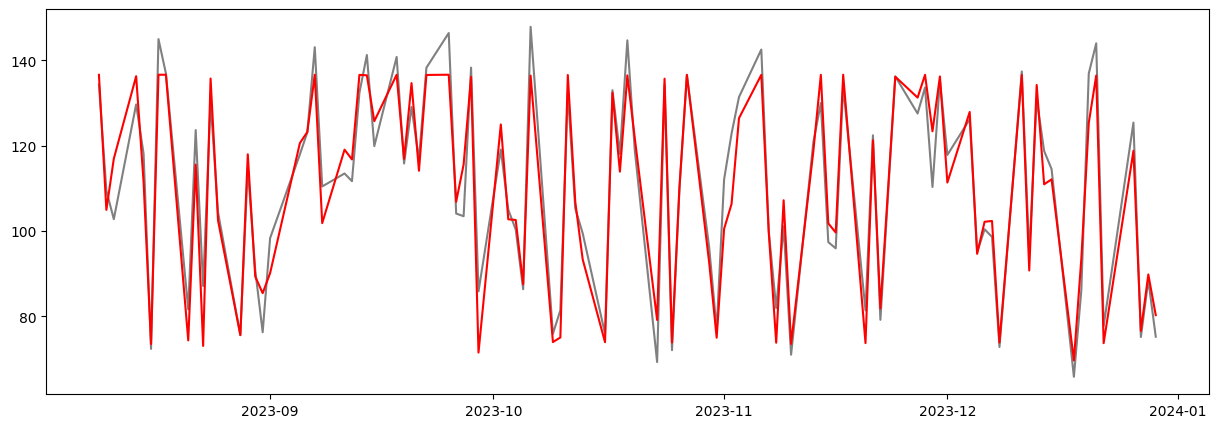

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,y_pred,color='red',label='predict')
plt.show()

# ENN

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

## 构建网络

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten
from tensorflow.keras.regularizers import l1_l2

# alpha是正则化项的强度，l1_ratio是L1正则化相对于L2的比例
alpha = 0.01
l1_ratio = 0.5
regularizer = l1_l2(l1=alpha * l1_ratio, l2=alpha * (1 - l1_ratio))

model = Sequential(name="ENN")
model.add(Dense(32, activation='relu', input_shape=X.shape[1:], kernel_regularizer=regularizer))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizer))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(32,activation='relu',kernel_regularizer=regularizer))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear', kernel_regularizer=regularizer))
model.summary()

In [ ]:
X.shape[1:]

In [ ]:
model.compile(optimizer='adam',loss='mse',metrics=['mape'])
model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test))

## 推理

In [ ]:
y_pred = model.predict(X_test)
print(y_pred)

In [ ]:
print(X_test.shape)
print(y_test.shape)
print(y_pred.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,y_pred,color='red',label='predict')
plt.show()

# WNN

In [ ]:
from sklearn.model_selection import train_test_split
import pywt  # 小波变换库

coefficients = pywt.wavedec2(X, 'db1', level=1)  # 使用db1小波和一层分解
input_shape = coefficients[0].shape  # 更新输入形状以匹配小波变换后的数据
X_train,X_test,y_train,y_test = train_test_split(coefficients[0],y,test_size=0.1)

## 构建网络

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten
from tensorflow.keras.regularizers import l1_l2

# coefficients = pywt.wavedec2(X, 'db1', level=1)  # 使用db1小波和一层分解
# input_shape = coefficients[0].shape  # 更新输入形状以匹配小波变换后的数据

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=input_shape[1:]))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.summary()

In [ ]:
model.compile(optimizer='adam',loss='mse',metrics=['mape'])
model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test))

## 推理

In [ ]:
y_pred = model.predict(X_test)
print(y_pred)

In [ ]:
print(X_test.shape)
print(y_test.shape)
print(y_pred.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,y_pred,color='red',label='predict')
plt.show()

# RBFNN 待续

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda,Layer
from tensorflow.keras.layers import Wrapper
from tensorflow.keras.optimizers import Adam

class RBFLayer(Layer):
    def __init__(self, units, gamma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma
        # 将RBF中心初始化为输入的均值（或随机值）
        self.centers = self.add_weight(name='centers',
                                       shape=(units,),
                                       initializer='zeros',
                                       trainable=True)

    def call(self, inputs):
        # 计算输入和中心之间的差的平方和
        squared_diff = tf.reduce_sum(tf.square(inputs[:, None, :] - self.centers[None, :, :]), axis=-1)
        # 应用径向基函数
        return tf.exp(-self.gamma * squared_diff)

    def compute_output_shape(self, input_shape):
        # 输出形状与输入样本数相同
        return (input_shape[0], self.units)

In [ ]:
model = Sequential()
model.add(RBFLayer(Dense(64), gamma=0.5, input_shape=(25,)))
model.add(Dense(1),activation='linear')
model.summary()


In [ ]:

X_train.shape

In [ ]:
rbf_matrix.shape

# LS-SVM

In [1]:
from sklearn.model_selection import train_test_split
X_flattened = X.reshape(X.shape[0], -1)  # (样本数, 25)
X_train,X_test,y_train,y_test = train_test_split(X_flattened,y,test_size=0.1)

NameError: name 'X' is not defined

In [ ]:
X_flattened.shape

In [ ]:
import numpy as np
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# 创建LS-SVM回归模型
# 创建LS-SVM回归模型，使用RBF核函数
model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.1))

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

In [ ]:
print(X_test.shape)
print(y_test.shape)
print(y_pred.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,y_pred,color='red',label='predict')
plt.show()

# SSM

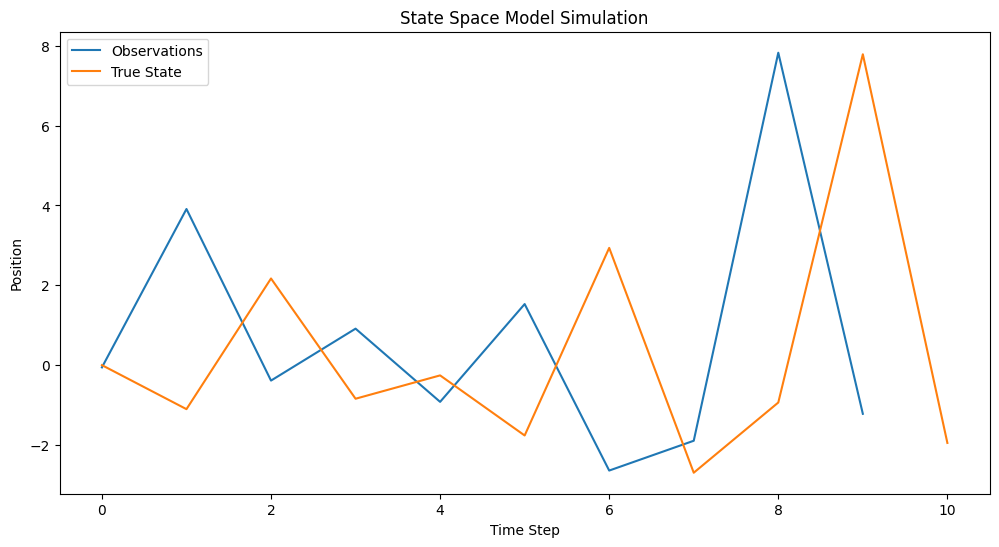

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# 定义时间步长
dt = 0.1

# 定义状态转移矩阵 A 和输入矩阵 B
A = np.array([[1.0, dt],
              [0.0, 1.0]])
B = np.array([[0.5 * dt**2],
              [dt]])

# 定义观测矩阵 C 和观测噪声矩阵 D
C = np.array([[1.0, 0.0]])
D = np.array([[0.0]])

# 定义初始状态和初始状态协方差
x0 = np.array([0.0, 0.0])
P0 = np.eye(2)

# 模拟过程，例如10个时间步长
num_steps = 10

# 用于存储状态和观测结果的列表
states = [x0]
observations = []

for t in range(num_steps):
    # 状态转移
    x = A @ x0 + np.random.multivariate_normal([0, 0], P0)
    states.append(x)
    
    # 观测
    y = C @ x + np.random.normal(0, 1)
    observations.append(y)
    
    # 更新状态协方差矩阵 P0（这里简化处理，实际应用中需要考虑预测和更新步骤）
    P0 = A @ P0 @ A.T + np.eye(2)

# 绘制状态和观测结果
plt.figure(figsize=(12, 6))
plt.plot(observations, label='Observations')
plt.plot([states[i][0] for i in range(num_steps + 1)], label='True State')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.title('State Space Model Simulation')
plt.show()

In [94]:
# Mamba
import numpy as np

class SSM:
    def __init__(self, state_dim, input_dim):
        self.A = np.eye(state_dim)  # 状态转移矩阵，可以设计为更复杂的结构
        self.B = np.zeros((state_dim, input_dim))  # 输入矩阵
        self.C = np.zeros((1, state_dim))  # 输出矩阵

    def forward(self, x):
        h = self.A @ x + self.B @ self.input  # 状态更新
        y = self.C @ h  # 输出计算
        return y, h

In [ ]:
class SelectiveSSM(SSM):
    def forward(self, x):
        # 根据输入数据x动态调整B和C
        self.B = self.update_B(x)
        self.C = self.update_C(x)
        
        # 执行状态更新和输出计算
        h = self.A @ x + self.B
        y = self.C @ h
        return y, h

    def update_B(self, x):
        # 示例：根据x更新B，实际实现可能更复杂
        return np.zeros_like(self.B) + x  # 这里仅为示例

    def update_C(self, x):
        # 示例：根据x更新C，实际实现可能更复杂
        return np.zeros_like(self.C) + x  # 这里仅为示例

In [ ]:
class MambaModel:
    def __init__(self, input_dim, hidden_dim, num_layers):
        self.layers = [SelectiveSSM(hidden_dim, input_dim) for _ in range(num_layers)]

    def forward(self, x):
        for layer in self.layers:
            x, _ = layer.forward(x)
        return x

In [ ]:
from torch import optim, nn

# 假设我们有一个训练数据集
train_data = ...

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mamba_model.parameters(), lr=0.001)

# 训练循环
for epoch in range(num_epochs):
    for x, y in train_data:
        optimizer.zero_grad()
        output = mamba_model.forward(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item()}")